<a href="https://colab.research.google.com/github/sethupavan12/nlp-hack/blob/main/main_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Install Stuff needed

In [112]:
pip install -q transformers

# Import Stuff needed

In [113]:
import pandas as pd
from ast import literal_eval
from tqdm.notebook import tqdm
tqdm.pandas()
from datetime import datetime
from transformers import pipeline

In [114]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
data_path = '/content/drive/MyDrive/hack/snacks_prep.csv'
print('Loading dataset at: ',datetime.now())
df = pd.read_csv(data_path, sep='\t', converters={'doc_entities': literal_eval, 'doc_keyphrases': literal_eval})
print('Loaded dataset at: ',datetime.now())

Loading dataset at:  2022-11-17 13:18:26.385206
Loaded dataset at:  2022-11-17 13:19:57.132552


# Check table

In [116]:
df.shape

(80460, 9)

In [117]:
df.head()

,id,sentence,doc_sentiment,doc_date,doc_title,doc_url,doc_entities,doc_keyphrases,doc_publish_location
0,U3-e4dabc69c877013e62dcfa2fbfdf29e4,"ATLANTA, March 29, 2017 /PRNewswire/ -- It's g...",0.125,2017-03-29T12:38:43Z,26¢ Pretzels to Celebrate Pretzelmaker's® 26th...,https://ceo.ca/@newswire/26-pretzels-to-celebr...,"[{'entityType': 'Organisation', 'name': 'PR Ne...","[pretzelmaker brand, happy birthday, hottest p...","Canada, Canada"
1,U3-e4dabc69c877013e62dcfa2fbfdf29e4,"In honor of Pretzelmaker's 26th birthday, the ...",0.125,2017-03-29T12:38:43Z,26¢ Pretzels to Celebrate Pretzelmaker's® 26th...,https://ceo.ca/@newswire/26-pretzels-to-celebr...,"[{'entityType': 'Organisation', 'name': 'PR Ne...","[pretzelmaker brand, happy birthday, hottest p...","Canada, Canada"
2,U3-e4dabc69c877013e62dcfa2fbfdf29e4,"* For 26 years, Pretzelmaker has served up fre...",0.125,2017-03-29T12:38:43Z,26¢ Pretzels to Celebrate Pretzelmaker's® 26th...,https://ceo.ca/@newswire/26-pretzels-to-celebr...,"[{'entityType': 'Organisation', 'name': 'PR Ne...","[pretzelmaker brand, happy birthday, hottest p...","Canada, Canada"
3,U3-e4dabc69c877013e62dcfa2fbfdf29e4,"On National Pretzel Day, the brand will celebr...",0.125,2017-03-29T12:38:43Z,26¢ Pretzels to Celebrate Pretzelmaker's® 26th...,https://ceo.ca/@newswire/26-pretzels-to-celebr...,"[{'entityType': 'Organisation', 'name': 'PR Ne...","[pretzelmaker brand, happy birthday, hottest p...","Canada, Canada"
4,U3-e4dabc69c877013e62dcfa2fbfdf29e4,"To get the country fired up for April 26, Pret...",0.125,2017-03-29T12:38:43Z,26¢ Pretzels to Celebrate Pretzelmaker's® 26th...,https://ceo.ca/@newswire/26-pretzels-to-celebr...,"[{'entityType': 'Organisation', 'name': 'PR Ne...","[pretzelmaker brand, happy birthday, hottest p...","Canada, Canada"


In [118]:
df.columns

Index(['id', 'sentence', 'doc_sentiment', 'doc_date', 'doc_title', 'doc_url',
       'doc_entities', 'doc_keyphrases', 'doc_publish_location'],
      dtype='object')

# Clean Dataset

In [119]:
df['sentence'] = df['sentence'].fillna('')
df = df[~df['sentence'].str.contains('http')] 
df = df[~df['sentence'].str.contains('www')]
# remove the words that starts with @
df = df[~df['sentence'].str.contains('@')]
df['sentence'] = df['sentence'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [120]:
valuecounting = df.doc_publish_location.value_counts().to_dict()
countries=[]
for key,value in valuecounting.items():
  if ',' in key:
    country = key.split(",",1)[1]
    countries.append(country)
    df["doc_publish_location"]=df["doc_publish_location"].replace([key], country, regex=True)

df.doc_publish_location.value_counts()

 United States            16306
 United Kingdom           14435
 France                    1877
 Japan                     1739
 India                     1567
                          ...  
 Gibraltar                    4
 Saint Kitts and Nevis        4
 Saudi Arabia                 2
 Italy                        1
 Georgia                      1
Name: doc_publish_location, Length: 75, dtype: int64

# Sentiment Stuff

In [121]:
interesting = df.drop(['id','doc_date', 'doc_title', 'doc_url', 'doc_entities', 'doc_keyphrases', 'doc_publish_location'], axis=1)
interesting


,sentence,doc_sentiment
0,ATLANTA March 29 2017 PRNewswire Its going to...,0.125
1,In honor of Pretzelmakers 26th birthday the ha...,0.125
2,For 26 years Pretzelmaker has served up fresh...,0.125
3,On National Pretzel Day the brand will celebra...,0.125
4,To get the country fired up for April 26 Pretz...,0.125
...,...,...
80455,Health Minister Olivier Veran said that would ...,-0.100
80456,The wave linked to the Delta variant is clearl...,-0.100
80457,France reported over 425000 coronavirus infect...,-0.100
80458,The vaccine pass approved by parliament on Sun...,-0.100


Load transformer


In [122]:
sentiment_pipeline = pipeline("sentiment-analysis") # not using atm

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Make a new col with postiive or negative setiment

In [123]:
df['sentiment'] = df['doc_sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative')

# EXPORT THE CLEAN CSV

In [124]:
df = df.drop(['id'], axis =1)

In [125]:
df['doc_date'] = pd.to_datetime(df['doc_date'],format='%Y-%m-%dT%H:%M:%SZ')

In [126]:
df = df.drop(['doc_url'], axis = 1)

In [127]:
cf = (df)
cf['doc_publish_location'] = cf['doc_publish_location'].str.split(',').str[0]

In [128]:
df.to_csv('cleanedDF.csv')

# Where is popcorn  most spoken about?

In [129]:
popcorn_sentences = df[df['sentence'].str.contains('popcorn')]

In [130]:
popcorn_sentences[:10]

,sentence,doc_sentiment,doc_date,doc_title,doc_entities,doc_keyphrases,doc_publish_location,sentiment
40,If youve got plans to get comfy on the sofa wi...,0.272727,2021-02-11 15:12:34,15 Valentine's Day gifts for dogs including do...,"[{'entityType': 'Organisation', 'name': 'Pets ...","[gift a dog, delicious valentine, toy collecti...",United Kingdom,positive
112,Sevenyearold Rabu does not like going to the d...,-0.066667,2022-03-26 00:04:44,Popcorn-smelling bearcat at Perth Zoo taken to...,"[{'entityType': 'Person', 'name': 'Rabu', 'id'...","[seven-year-old rabu, specialist dentists, bel...",Australia,negative
149,Just use the silicone lid to measure popcorn k...,0.047619,2020-09-11 17:26:09,Elevate Movie Night with the Best Popcorn Makers,"[{'entityType': 'Product', 'name': 'Variety (m...","[great popcorn, popcorn kernels, small applian...",United States,positive
164,A explosion is under way in the popcorn busine...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
165,With sales up more than 10 this year to 152m t...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
168,Our stuff is all about natural ingredients say...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
169,Inspired by his father most parents would cook...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
171,Another brand driving the popcorn resurgence P...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
173,Stavrous passion for popcorn dates back to her...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive
174,We were one of the first new breed of popcorn ...,0.250000,2017-09-29 14:06:12,Popcorn sales explosion makes it UK's fastest-...,"[{'entityType': 'Country', 'name': 'United Kin...","[popcorn resurgence, popcorn business, british...",United Kingdom,positive


Given a snack name, find the country that speaks of this snake the most

In [131]:
  # Find highest talked of country
  def find_snack_highest_talked_country(snack):
    countries = {}
    for country in df['doc_publish_location'].unique():
        countries[country] = df[df['doc_publish_location'] == country]['sentence'].str.contains(snack).sum()

    # Find the country that has the highest count
    return max(countries, key=countries.get)

  find_snack_highest_talked_country("pretzels")

' United States'

In [132]:
df['doc_publish_location'].unique()

array([' Canada', ' Ireland', ' United Kingdom', ' India', nan,
       ' United States', ' Australia', ' France', ' Lebanon', ' Germany',
       ' South Africa', ' New Zealand', ' Philippines', ' Mexico',
       ' Iran', ' Russia', ' Cyprus', ' Singapore', ' Hong Kong',
       ' European Union', ' United Arab Emirates', ' Japan', ' Spain',
       ' Brunei', ' Pakistan', ' Colombia', ' Netherlands', ' Nigeria',
       ' Luxembourg', ' Jordan', ' China', ' Indonesia', ' Venezuela',
       ' Azerbaijan', ' Malaysia', ' Montenegro', ' Bangladesh',
       ' Bahrain', ' Kenya', ' Viet Nam', ' Uganda', ' Oman', ' Ghana',
       ' Croatia', ' Latvia', ' Tanzania', ' Taiwan', ' Gibraltar',
       ' Italy', ' Ukraine', ' Switzerland', ' Saint Kitts and Nevis',
       ' Jamaica', ' Argentina', ' Greece', ' Thailand', ' Georgia',
       ' Rwanda', ' Poland', ' Turkey', ' Israel', ' Saudi Arabia',
       ' Denmark', ' Sri Lanka', ' Trinidad and Tobago', ' Zimbabwe',
       ' Austria', ' Libya', ' S

In [177]:
north_america = [" United States", " Canada", "Mexico"]
north_america_total = 0
south_america = [" Brazil", ' Columbia', ' Venuzuela', ' Argentina', ' Jamaica']
south_america_total = 0
europe = [' United Kingdom', ' France', ' Ireland', ' Germany', ' Spain', ' Montenegro', ' European Union',
            ' Cyprus', ' Austria', ' Netherlands', ' Croatia', ' Russia', ' Switzerland', ' Denmark', ' Malta',
            ' Latvia', ' Hungary', ' Luxembourg', ' Azerbaijan', ' Greece', ' Ukraine', ' Romania', ' Gibraltar',
            ' Italy', ' Georgia']
europe_total = 0
asia_total = 0
africa = [" South Africa", ' Nigeria', ' Kenya', ' Ghana', ' Zimbabwe', ' Trinidad and Tobago', ' Rwanda',
            ' Uganda', ' Tanzania']

africa_total = 0

def snack_continent(snack):
    global north_america_total
    global south_america_total
    global europe_total
    global asia_total
    global africa_total
    for i in north_america:
        north_america_total += len(df[(df['sentence'].str.contains(snack)) & (df['sentence'].str.contains(i))])
    for i in south_america:
        south_america_total += len(df[(df['sentence'].str.contains(snack)) & (df['sentence'].str.contains(i))])
    for i in europe:
        europe_total += len(df[(df['sentence'].str.contains(snack)) & (df['sentence'].str.contains(i))])
    for i in africa:
        africa_total += len(df[(df['sentence'].str.contains(snack)) & (df['sentence'].str.contains(i))])
    asia_total = len(df[(df['sentence'].str.contains(snack)) & (df['sentence'].str.contains(' Asia'))])
    answer = north_america_total, south_america_total, europe_total, asia_total, africa_total
    # scale the data to total to 1
    # make sure the answers are split into percentages of the total so that they can be compared
    percent = [i * 100/sum(answer) for i in answer]
    return percent 

In [178]:
snack_continent("popcorn")

[44.973544973544975,
 12.16931216931217,
 29.62962962962963,
 3.1746031746031744,
 10.052910052910052]

In [133]:
df.to_csv('cleanedDF.csv')

# Question Answering

In [134]:
model_name = "deepset/roberta-base-squad2"
fb_ai = pipeline('question-answering', model=model_name, tokenizer=model_name)


In [135]:
q_a = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


Given a topic, answers any question

In [136]:
topic = "Walnuts"
x = ' '.join(interesting[interesting['sentence'].str.contains(topic)]['sentence'])


In [137]:
len(x)

9571

GOOD model by Facebook

In [138]:
if len(x) > 25000:
  x = x[:10000]
QA_input = {
    'question': "What are some famous walnut types?",
    'context': x
}
result = fb_ai(QA_input)
print(result['answer'])

Organic Walnuts and Organic Walnuts with Apple Cinnamon


In [139]:
result = q_a(context=x , question = "What are some famous walnut types?")
print(result)

{'score': 0.5970888733863831, 'start': 0, 'end': 7, 'answer': 'Walnuts'}


In [ ]:
df['sentence'].tolist()

# Snack Statistics



In [141]:
snacks ={
    "pretzels": 0,
    "cashew nuts": 0,
    "american pecan":0,
    "first class nuts":0,
    "popcorn": 0,
    "chocolate": 0,
    "flipz salted caramel": 0,
    "walnut":0,
    "crips":0,
    "granola bars":0
}

# get the number of times each snack is spoken in the interesting['sentence'] column
for snack in snacks:
    snacks[snack] = interesting['sentence'].str.contains(snack).sum()

snacks

{'pretzels': 1351,
 'cashew nuts': 176,
 'american pecan': 0,
 'first class nuts': 1,
 'popcorn': 4905,
 'chocolate': 761,
 'flipz salted caramel': 0,
 'walnut': 390,
 'crips': 7,
 'granola bars': 4}

Popcorn

In [142]:
popcorn_sentences = df[df['sentence'].str.contains('popcorn')]

# Counts of pretzels
popcorn_count = snacks["popcorn"]
print(popcorn_count)
# Average sentiment of pretzels sentences using the doc_sentiment column
mean = popcorn_sentences['doc_sentiment'].mean()
if mean > 0:
    print('The average sentiment of popcorn sentences is positive - ', mean)
else:
    print('The average sentiment of popcorn sentences is negative - ', mean)

# What country talks about pretzels the most?
popcorn_sentences['doc_publish_location'].value_counts().index[0]

4905
The average sentiment of popcorn sentences is positive -  0.13102653379429152


' United States'

**Pretzels**

In [143]:
pretzels_sentences = df[df['sentence'].str.contains('pretzels')]

# Counts of pretzels
pretzel_count = snacks["pretzels"]
print(pretzel_count)
# Average sentiment of pretzels sentences using the doc_sentiment column
mean = pretzels_sentences['doc_sentiment'].mean()
if mean > 0:
    print('The average sentiment of pretzels sentences is positive - ', mean)
else:
    print('The average sentiment of pretzels sentences is negative - ', mean)

# What country talks about pretzels the most?
pretzels_sentences['doc_publish_location'].value_counts().index[0]

1351
The average sentiment of pretzels sentences is positive -  0.10572268531532197


' United States'

In [144]:
chocolate_sentences = df[df['sentence'].str.contains('chocolate')]

# Counts of pretzels
chocolate_count = snacks["chocolate"]
print(chocolate_count)
# Average sentiment of chocolate sentences using the doc_sentiment column
mean = chocolate_sentences['doc_sentiment'].mean()
if mean > 0:
    print('The average sentiment of chocolate sentences is positive - ', mean)
else:
    print('The average sentiment of chocolate  sentences is negative - ', mean)

# What country talks about pretzels the most?
chocolate_sentences['doc_publish_location'].value_counts().index[0]

761
The average sentiment of chocolate sentences is positive -  0.11197363744546651


' United Kingdom'

In [145]:
walnut_sentences = df[df['sentence'].str.contains('walnut')]

# Counts of pretzels
walnut_count = snacks["walnut"]
print(walnut_count)
# Average sentiment of walnut sentences using the doc_sentiment column
mean = walnut_sentences['doc_sentiment'].mean()
if mean > 0:
    print('The average sentiment of walnut sentences is positive - ', mean)
else:
    print('The average sentiment of walnut sentences is negative - ', mean)

# What country talks about pretzels the most?
walnut_sentences['doc_publish_location'].value_counts().index[0]

390
The average sentiment of walnut sentences is positive -  0.018351739038461542


' United States'

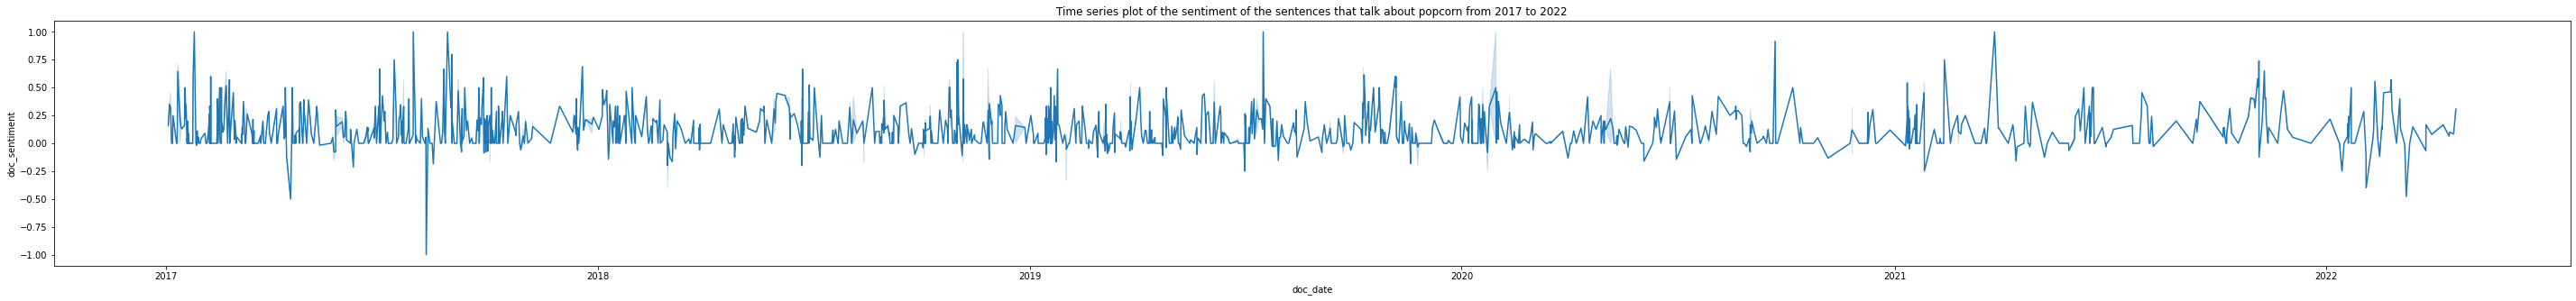

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(50, 5))
sns.lineplot(x='doc_date', y='doc_sentiment', data=popcorn_sentences)
plt.title('Time series plot of the sentiment of the sentences that talk about popcorn from 2017 to 2022')
plt.show()


Sentiment of a popcorn over a period of time

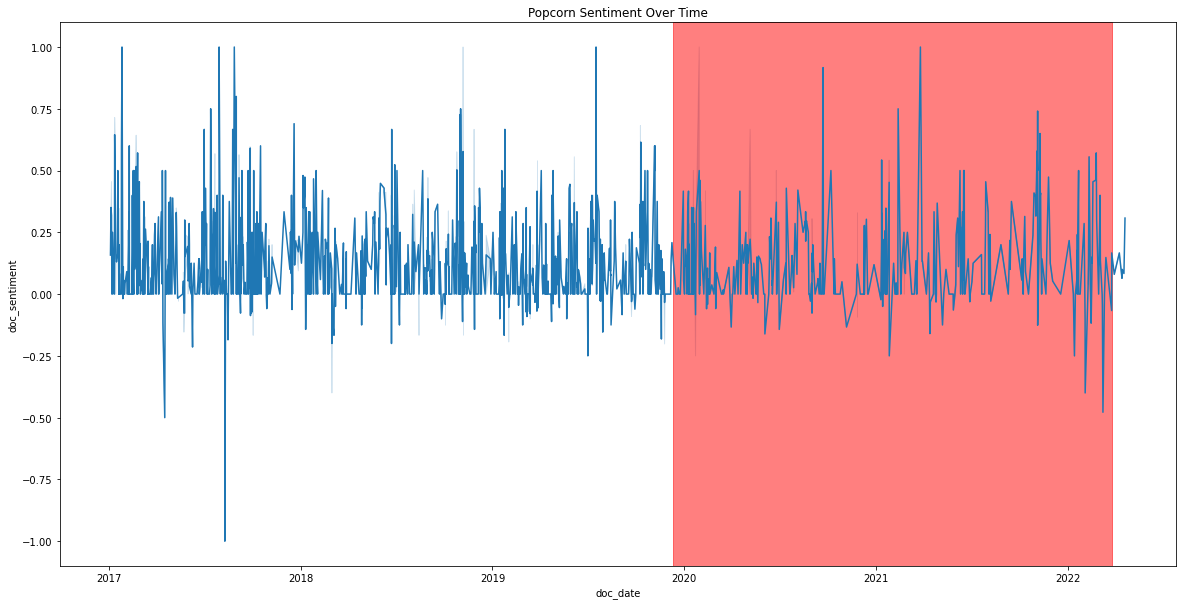

In [190]:
# Find the sentences that talk about popcorn and get their doc_date and doc_sentiment
popcorn = df[df['sentence'].str.contains('popcorn')][['doc_date', 'doc_sentiment']]

# convert doc_date to datetime
popcorn['doc_date'] = pd.to_datetime(popcorn['doc_date'], format='%Y-%m-%dT%H:%M:%SZ')
# Smooth the sentiment data
popcorn['doc_sentiment'] = popcorn['doc_sentiment']
# plot the doc_sentiment over time
plt.figure(figsize=(20, 10))
plt.axvspan(pd.to_datetime("2019-12-11 15:12:34"), pd.to_datetime("2022-03-26 00:04:44"), color='red', alpha=0.5)
sns.lineplot(x='doc_date', y='doc_sentiment', data=popcorn)

plt.title('Popcorn Sentiment Over Time')
plt.show()





**Snakes over a period of time**

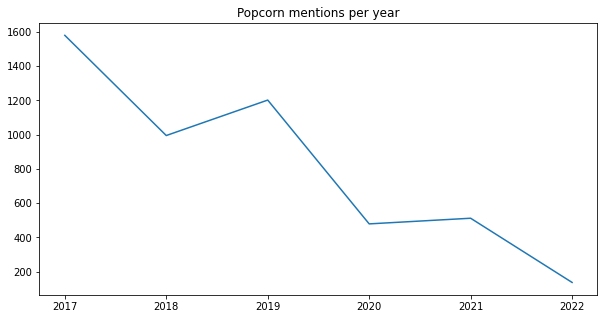

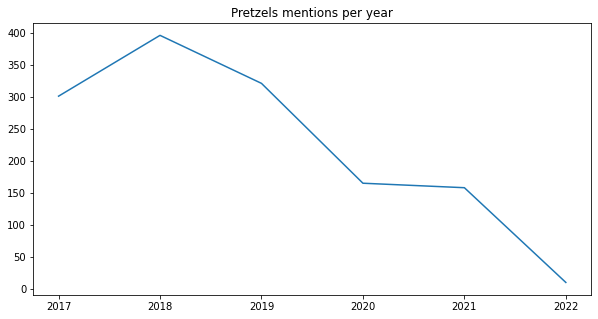

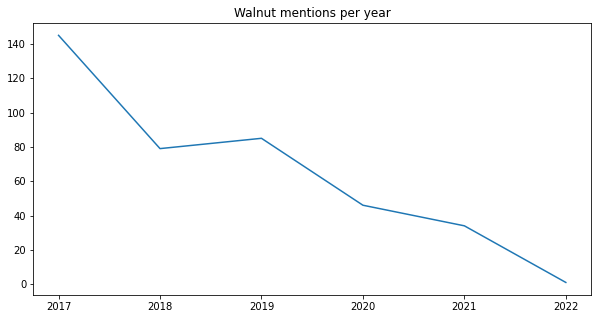

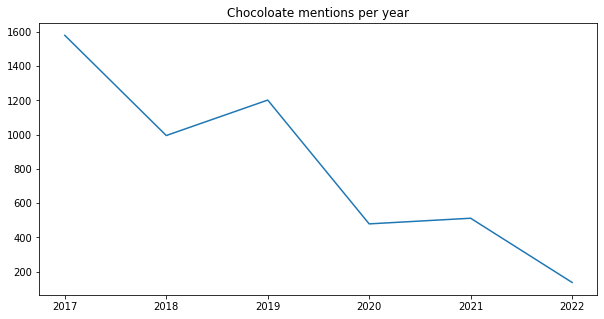

In [179]:
popcorn_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in popcorn_per_year:
    popcorn_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('popcorn').sum()

walnut_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in walnut_per_year:
    walnut_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('walnut').sum()


pretzels_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in pretzels_per_year:
    pretzels_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('pretzels').sum()



choco_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in choco_per_year:
    choco_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('chocolate').sum()

# Plot the frequency of popcorn sentences per year
x = list(popcorn_per_year.keys())
y = list(popcorn_per_year.values())
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Popcorn mentions per year')
plt.show()

x = list(pretzels_per_year.keys())
y = list(pretzels_per_year.values())
# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Pretzels mentions per year')
plt.show()


x = list(walnut_per_year.keys())
y = list(walnut_per_year.values())

# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Walnut mentions per year')
plt.show()



x = list(choco_per_year.keys())
y = list(popcorn_per_year.values())
# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Chocoloate mentions per year')
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


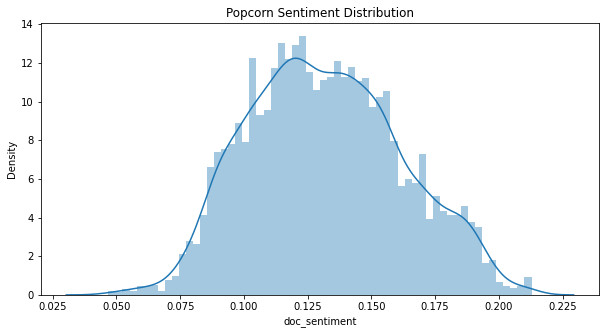

In [185]:
popcorn = df[df['sentence'].str.contains('popcorn')][['doc_date', 'doc_sentiment']]
popcorn['doc_sentiment'] = popcorn['doc_sentiment'].rolling(100).mean()
plt.figure(figsize=(10, 5))
sns.distplot(popcorn['doc_sentiment'], bins=60)
plt.title('Popcorn Sentiment Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


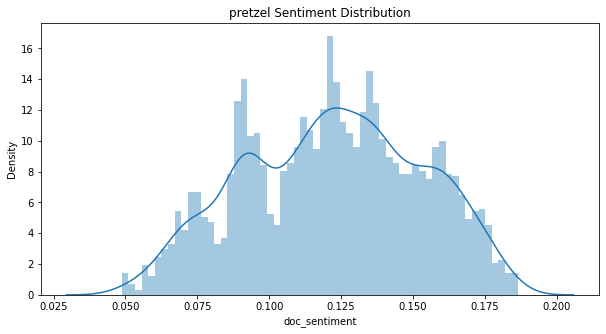

In [186]:
pretzel = df[df['sentence'].str.contains('pretzel')][['doc_date', 'doc_sentiment']]
pretzel['doc_sentiment'] = pretzel['doc_sentiment'].rolling(100).mean()
plt.figure(figsize=(10, 5))
sns.distplot(pretzel['doc_sentiment'], bins=60)
plt.title('pretzel Sentiment Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


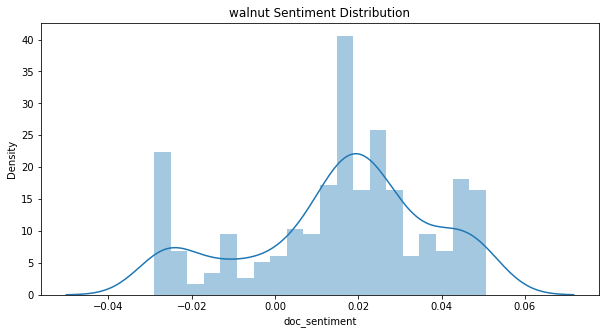

In [188]:
walnut = df[df['sentence'].str.contains('walnut')][['doc_date', 'doc_sentiment']]
walnut['doc_sentiment'] = walnut['doc_sentiment'].rolling(100).mean()
plt.figure(figsize=(10, 5))
sns.distplot(walnut['doc_sentiment'], bins=20)
plt.title('walnut Sentiment Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


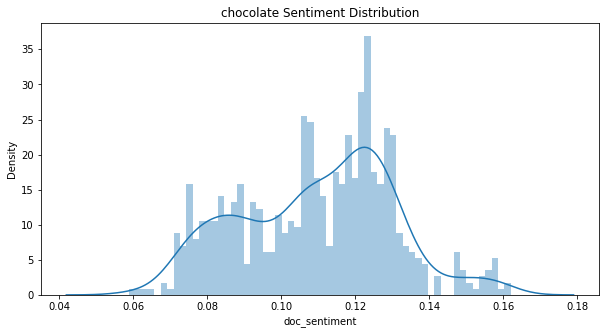

In [189]:
chocolate = df[df['sentence'].str.contains('chocolate')][['doc_date', 'doc_sentiment']]
chocolate['doc_sentiment'] = chocolate['doc_sentiment'].rolling(100).mean()
plt.figure(figsize=(10, 5))
sns.distplot(chocolate['doc_sentiment'], bins=60)
plt.title('chocolate Sentiment Distribution')
plt.show()

# Forecasting

In [151]:
forecast_df =df[df['sentence'].str.contains('popcorn')][['doc_date', 'doc_sentiment']]

In [152]:
forecast_df = forecast_df.rename(columns={'doc_date': 'ds', 'doc_sentiment': 'y'})
forecast_df = forecast_df.dropna()

In [153]:
forecast_df

,ds,y
40,2021-02-11 15:12:34,0.272727
112,2022-03-26 00:04:44,-0.066667
149,2020-09-11 17:26:09,0.047619
164,2017-09-29 14:06:12,0.250000
165,2017-09-29 14:06:12,0.250000
...,...,...
80366,2019-01-19 00:00:00,0.000000
80370,2019-01-19 00:00:00,0.000000
80371,2019-01-19 00:00:00,0.000000
80372,2019-01-19 00:00:00,0.000000


In [154]:
from pandas import read_csv
from pandas import to_datetime
from prophet import Prophet
forecast_df['ds']= to_datetime(forecast_df['ds'])
model = Prophet()
# fit the model
model.fit(forecast_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp73kb7ivv/_bhuigh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp73kb7ivv/wfvep3wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65123', 'data', 'file=/tmp/tmp73kb7ivv/_bhuigh5.json', 'init=/tmp/tmp73kb7ivv/wfvep3wt.json', 'output', 'file=/tmp/tmp73kb7ivv/prophet_modelfzyzebcl/prophet_model-20221117132152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [155]:
future = list()
for i in range(1, 13):
	date = '2019-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [156]:
forecast_df

,ds,y
40,2021-02-11 15:12:34,0.272727
112,2022-03-26 00:04:44,-0.066667
149,2020-09-11 17:26:09,0.047619
164,2017-09-29 14:06:12,0.250000
165,2017-09-29 14:06:12,0.250000
...,...,...
80366,2019-01-19 00:00:00,0.000000
80370,2019-01-19 00:00:00,0.000000
80371,2019-01-19 00:00:00,0.000000
80372,2019-01-19 00:00:00,0.000000


          ds      yhat  yhat_lower  yhat_upper
0 2019-01-01  0.221758    0.020657    0.438867
1 2019-02-01  0.073624   -0.128605    0.267701
2 2019-03-01  0.056246   -0.151327    0.268821
3 2019-04-01  0.081503   -0.106292    0.281886
4 2019-05-01  0.117614   -0.089281    0.315687


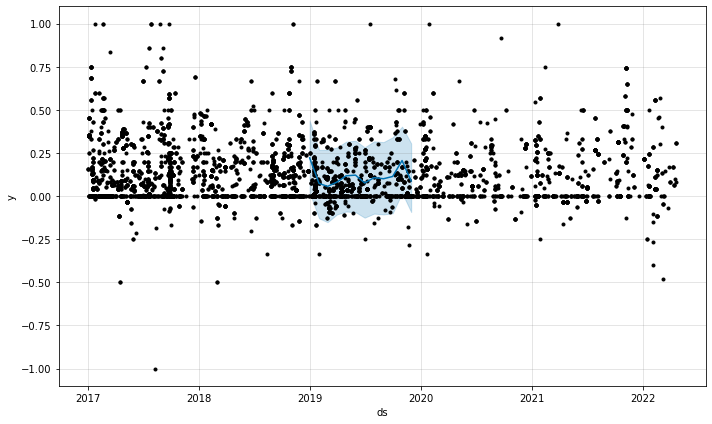

In [157]:
import matplotlib
import matplotlib.pyplot as plt
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

MAE: 0.098


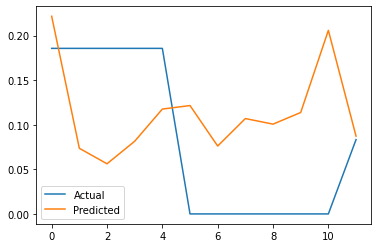

In [158]:
y_true = forecast_df['y'][-12:].values
y_pred = forecast['yhat'].values
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Snacks mention over years

In [181]:
df.describe()

,doc_sentiment
count,79189.000000
mean,0.083118
std,0.146242
min,-1.000000
25%,0.000000
50%,0.043478
75%,0.148936
max,1.000000


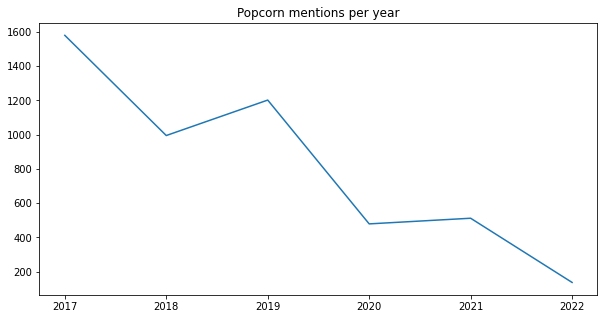

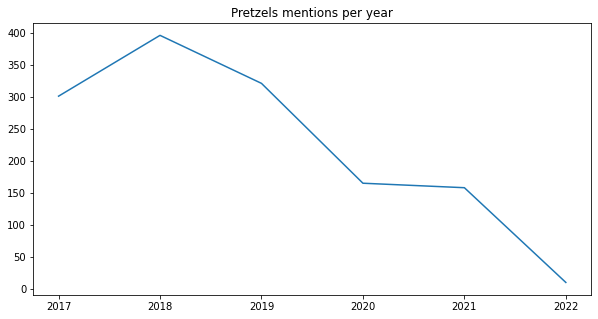

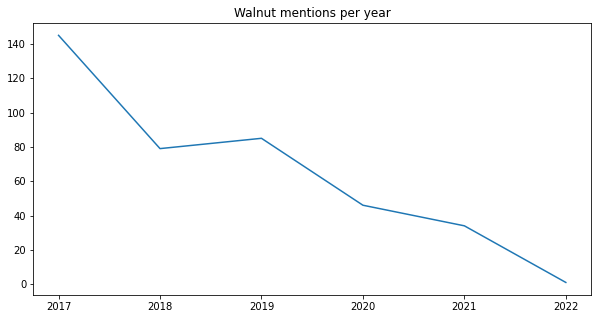

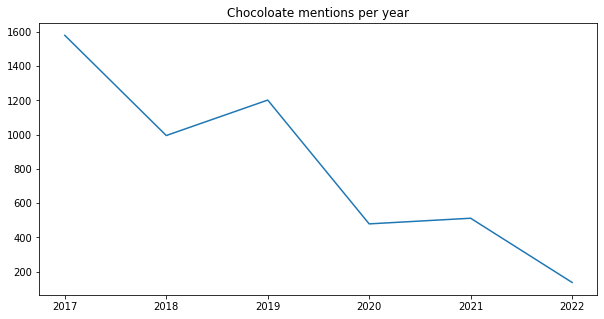

In [159]:
popcorn_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in popcorn_per_year:
    popcorn_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('popcorn').sum()

walnut_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in walnut_per_year:
    walnut_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('walnut').sum()


pretzels_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in pretzels_per_year:
    pretzels_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('pretzels').sum()



choco_per_year = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}

for year in choco_per_year:
    choco_per_year[year] = df[df['doc_date'].dt.year == year]['sentence'].str.contains('chocolate').sum()

# Plot the frequency of popcorn sentences per year
x = list(popcorn_per_year.keys())
y = list(popcorn_per_year.values())
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Popcorn mentions per year')
plt.show()

x = list(pretzels_per_year.keys())
y = list(pretzels_per_year.values())
# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Pretzels mentions per year')
plt.show()


x = list(walnut_per_year.keys())
y = list(walnut_per_year.values())

# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Walnut mentions per year')
plt.show()



x = list(choco_per_year.keys())
y = list(popcorn_per_year.values())
# Plot the frequency of popcorn sentences per year
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Chocoloate mentions per year')
plt.show()
